In [2]:
from __future__ import print_function
import pandas as pd
import numpy as np
import sys
sys.path.append('../../')
import kang
from IPython.display import SVG, display

In [83]:
# Thalemine annotation import
import pandas as pd
from intermine.webservice import Service
def get_info_thale(genelist): # genelist should be consisted with genenames
    service = Service("https://apps.araport.org/thalemine/service")
    dic = {"organism.shortName" : [],
           "primaryIdentifier" : [],
           "briefDescription" : [],
           "symbol" : [],
           "description" : [],
           "Name" : []
           }
    # The view specifies the output columns
    for gene in genelist:
        query = service.new_query("Gene")
        query.add_view(
        "primaryIdentifier", "briefDescription", "symbol",
        "description", "organism.shortName","name"
        )
        query.add_constraint("primaryIdentifier", "=", gene, code = "A")
        for row in query.rows():
            dic["organism.shortName"].append(row["organism.shortName"])
            dic["primaryIdentifier"].append(row["primaryIdentifier"])
            dic["briefDescription"].append(row["briefDescription"])
            dic["symbol"].append(row["symbol"])
            dic["description"].append(row["description"])
            dic["Name"].append(row["name"])
                
    return dic

In [37]:
file_ip_ATAH = '../../../DroughtNet/inparanoid/table.AT-AH'
file_ip_ATES = '../../../DroughtNet/inparanoid/table.AT-ES'
file_ip_ATAL = '../../../DroughtNet/inparanoid/table.AT-AL'
file_ip_ATAH1 = '../../../DroughtNet/inparanoid/table.AT-AH1'

df_ip_ATAH   = pd.read_csv(file_ip_ATAH,sep='\t')
df_ip_ATAH['OrtoA.genename'] = df_ip_ATAH['OrtoA'].apply(lambda x: x.split()[0])
df_ip_ATAH['OrtoB.genename'] = df_ip_ATAH['OrtoB'].apply(lambda x: x.split()[0])
df_ip_ATAH_index= df_ip_ATAH.set_index('OrtoA.genename')
df_ip_ATES   = pd.read_csv(file_ip_ATES,sep='\t')
df_ip_ATES['OrtoA.genename'] = df_ip_ATES['OrtoA'].apply(lambda x: x.split()[0])
df_ip_ATES['OrtoB.genename'] = df_ip_ATES['OrtoB'].apply(lambda x: x.split()[0])
df_ip_ATES_index= df_ip_ATES.set_index('OrtoA.genename')
df_ip_ATAL   = pd.read_csv(file_ip_ATAL,sep='\t')
df_ip_ATAL['OrtoA.genename'] = df_ip_ATAL['OrtoA'].apply(lambda x: x.split()[0])
df_ip_ATAL['OrtoB.genename'] = df_ip_ATAL['OrtoB'].apply(lambda x: x.split()[0])
df_ip_ATAL_index= df_ip_ATAL.set_index('OrtoA.genename')

df_ip_ATAH1   = pd.read_csv(file_ip_ATAH1,sep='\t')
df_ip_ATAH1['OrtoA.genename'] = df_ip_ATAH1['OrtoA'].apply(lambda x: x.split()[0])
df_ip_ATAH1['OrtoB.genename'] = df_ip_ATAH1['OrtoB'].apply(lambda x: x.split()[0])
df_ip_ATAH1_index= df_ip_ATAH1.set_index('OrtoA.genename')

In [45]:
file_pep_at = '../../../DroughtNet/blast/Athaliana_167.fa.pep.fa'
dic_pep_at  = kang.Fasta2dic(file_pep_at)
file_pep_al = '../../../DroughtNet/blast/Alyrata_107_v1.fa.pep.fa'
dic_pep_al  = kang.Fasta2dic(file_pep_al)
file_pep_es = '../../../DroughtNet/blast/Esalsugineum_173_v1.fa.pep.fa'
dic_pep_es  = kang.Fasta2dic(file_pep_es)
file_pep_ah = '../../../DroughtNet/blast/Ahalleri_264_v1.fa.pep.fa'
dic_pep_ah  = kang.Fasta2dic(file_pep_ah)
file_pep_ah1 = '../../../DroughtNet/blast/AhRNASeqAss.fasta.transdecoder.pep.num.fa.cdhit.fa'
dic_pep_ah1  = kang.Fasta2dic(file_pep_ah1)

In [19]:
df_ortholog = pd.DataFrame(pd.Series(dic_pep_at.keys()),columns=['Genename'])

In [179]:
def get_orth(x,df):
    try:
        return df.loc[x]['OrtoB.genename']
    except KeyError:
        return 'NaN'
        
df_ortholog['ALY'] = df_ortholog['Genename'].apply(get_orth,args=(df_ip_ATAL_index,))
df_ortholog['ESA'] = df_ortholog['Genename'].apply(get_orth,args=(df_ip_ATES_index,))
df_ortholog['AHA'] = df_ortholog['Genename'].apply(get_orth,args=(df_ip_ATAH_index,))
df_ortholog['AHA1'] = df_ortholog['Genename'].apply(get_orth,args=(df_ip_ATAH1_index,))

In [180]:
df_ortholog_index = df_ortholog.set_index('Genename')

In [24]:
md               = 100
query_rad        = 10

def get_xy(ms):

    l                = (1-ms)**2 * md + query_rad + 5 # square amplify signal
    theta            = (1-ms) * np.pi*2
    x                = l * np.cos(theta)
    y                = l * np.sin(theta)
    #print(ms,l,theta)
    return l,theta,x,y
get_xy_vec = np.vectorize(get_xy)

In [25]:
def get_df_bo(file_bo,dic):
    #file_bo = './blast/Athaliana_167.fa.pep.fa.bp.ev1e5.out7.rmsharp.txt'
    df_bo   = pd.read_csv(file_bo,sep='\t',header=None)
    mask      = (df_bo[10] < 1*np.exp(-5)) & (df_bo[2] > 30 )
    df_bo_cut = df_bo[mask]
    df_bo_cut['ql'] = df_bo_cut[0].apply(lambda x : len(dic[str(x)]))
    df_bo_cut['sl'] = df_bo_cut[1].apply(lambda x : len(dic[str(x)]))
    df_bo_cut['msim'] = ((df_bo_cut[2]/100)*2*df_bo_cut[3])/(df_bo_cut['ql'] + df_bo_cut['sl'])
    l,theta,x, y = get_xy_vec(df_bo_cut['msim'])
    df_bo_cut['x'] = x
    df_bo_cut['y'] = y
    df_bo_cut['l'] = l
    df_bo_cut['theta'] = theta
    df_bo_cut[0] = df_bo_cut[0].astype(str)
    df_bo_cut_index = df_bo_cut.set_index(0)
    print (len(df_bo),len(df_bo_cut))
    return df_bo_cut_index

In [46]:
df_bo_at = get_df_bo('../../../DroughtNet/blast/Athaliana_167.fa.pep.fa.bp.ev1e5.out7.rmsharp.txt',dic_pep_at)
df_bo_al = get_df_bo('../../../DroughtNet/blast/Alyrata_107.fa.pep.fa.bp.ev1e5.out7.rmsharp.txt',dic_pep_al)
df_bo_es = get_df_bo('../../../DroughtNet/blast/Thalophila_173.fa.pep.fa.bp.ev1e5.out7.rmsharp.txt',dic_pep_es)
df_bo_ah = get_df_bo('../../../DroughtNet/blast/Ahalleri_264_v1.fa.pep.fa.bp.ev1e5.out7.rmsharp.txt',dic_pep_ah)
df_bo_ah1 = get_df_bo('../../../DroughtNet/blast/AhRNASeqAss.fasta.transdecoder.pep.num.fa.cdhit.fa.bp.ev1e5.out7.rmsharp.txt',dic_pep_ah1)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-

1964030 1008556
2078664 1137446
1989270 1006879
1691258 877743
2570447 1602709


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [223]:
def draw_genename(df,genename,Outfile=None):
    b = 0
    if Outfile==None:
        canvas_height = 500
        canvas_width  = 500

        text_size           = 15
        label_size          = 8
        label_size_genelist = 10

        xaxis            = 200 # xaxis location in svg space 
        yaxis            = 200
        b = 1
        Outfile = open(genename+'.singleboviz.svg','w')
        print('<svg height="%d" width="%d">'%(canvas_height,canvas_width),file=Outfile)    
    circle = '<circle cx="%d" cy="%d" r="%d" \
              style="fill:%s;stroke:black;stroke-width:1;fill-opacity:%f;stroke-opacity:0.9" />'
    line   = '<line x1="%d" y1="%d" x2="%d" y2="%d" stroke="%s" stroke-width="1" />' 
    text   = '<text text-anchor="middle" x="%d" y="%d" fill="black" font-size="%dpx">%s</text>'
    text_l = '<text text-anchor="left" x="%d" y="%d" fill="black" font-size="%dpx">%s</text>'
    text_i = '<text text-anchor="middle" x="%d" y="%d" fill="black" font-size="%dpx" font-style = "italic">%s</text>'
    if str(type(df.loc[genename])) == "<class 'pandas.core.frame.DataFrame'>":
        for j,(sgenename,x,y,msim) in enumerate(df.loc[genename][[1,'x','y','msim']].values):
            x1 = xaxis + x
            y1 = yaxis - y
            print(line%(xaxis,yaxis,x1,y1,'blue'),file=Outfile)
            print(circle%(x1,y1,5,'green',msim),file=Outfile)
            print(text%(x1,y1+1,label_size,(j+1)),file=Outfile)
            print(text_l%(xaxis,(yaxis + 100)+10*(j+1),label_size_genelist,str(sgenename)),file=Outfile)
    else:
        sgenename,x,y,msim = df.loc[genename][[1,'x','y','msim']].values
        x1 = xaxis + x
        y1 = yaxis - y
        print(line%(xaxis,yaxis,x1,y1,'blue'),file=Outfile)
        print(circle%(x1,y1,5,'green',msim),file=Outfile)
        print(text%(x1,y1+1,label_size,1),file=Outfile)
        print(text_l%(xaxis,(yaxis + 100)+10,label_size_genelist,str(sgenename)),file=Outfile)
    if b == 1:
        print(circle%(xaxis,yaxis,query_rad,'red',1),file=Outfile)
        print('</svg>',file=Outfile)
        Outfile.close()     
        display(SVG('./%s.singleboviz.svg'%(genename)))

In [218]:
def draw_orthologs(ath,commonname): # arabidopsis genename 
    a = df_bo_at.loc[ath]
    
    canvas_height = 500
    canvas_width  = 1200
    
    text_size           = 15
    label_size          = 8
    label_size_genelist = 10
    
    xaxis_pre        = 200 # xaxis location in svg space 
    yaxis            = 200
    Outfile       = open('%s.%s.orthoviz.svg'%(ath,commonname),'w')
    circle = '<circle cx="%d" cy="%d" r="%d" \
              style="fill:%s;stroke:black;stroke-width:1;fill-opacity:%f;stroke-opacity:0.9" />'
    line   = '<line x1="%d" y1="%d" x2="%d" y2="%d" stroke="%s" stroke-width="1" />' 
    text   = '<text text-anchor="middle" x="%d" y="%d" fill="black" font-size="%dpx">%s</text>'
    text_l = '<text text-anchor="left" x="%d" y="%d" fill="black" font-size="%dpx">%s</text>'
    text_i = '<text text-anchor="middle" x="%d" y="%d" fill="black" font-size="%dpx" font-style = "italic">%s</text>'
    print('<svg height="%d" width="%d">'%(canvas_height,canvas_width),file=Outfile)    
    print(text%(xaxis_pre*1,yaxis-50,text_size,ath),file=Outfile)
    print(text_i%(xaxis_pre*1,yaxis-70,text_size,'A.thaliana'),file=Outfile)
    print(text_i%(xaxis_pre*2,yaxis-70,text_size,'A.lyrata'),file=Outfile)
    print(text_i%(xaxis_pre*3,yaxis-70,text_size,'E.salsugineum'),file=Outfile)
    print(text_i%(xaxis_pre*4,yaxis-70,text_size,'A.halleri'),file=Outfile)
    print(text_i%(xaxis_pre*5,yaxis-70,text_size,'A.halleri_transcriptome'),file=Outfile)
    
    print(text%(xaxis_pre*0.5,yaxis-90,text_size,commonname),file=Outfile)
    
    if str(type(df_bo_at.loc[ath])) == "<class 'pandas.core.frame.DataFrame'>":
        ath_sgenelist = list(df_bo_at.loc[ath][1])
        ath_sgenelist = [x.split('.')[0] for x in ath_sgenelist]
        dic           = get_info_thale(ath_sgenelist)
        df_annot      = pd.DataFrame(dic)
        df_annot_ix   = df_annot.set_index('primaryIdentifier')
        for i,(sgenename,x,y,msim) in enumerate(df_bo_at.loc[ath][[1,'x','y','msim']].values):
            xaxis = xaxis_pre*1
            x1 = xaxis + x
            y1 = xaxis - y
            print(line%(xaxis,yaxis,x1,y1,'blue'),file=Outfile)
            print(circle%(x1,y1,5,'green',msim),file=Outfile)
            print(text%(x1,y1+1,label_size,(i+1)),file=Outfile)
            print(text_l%(xaxis,(yaxis + 100)+10*(i+1),label_size_genelist,str(i+1)+' '+df_annot_ix.loc[sgenename.split('.')[0]]['symbol']),file=Outfile)
            #print(x,y)
    else:
        ath_sgene = df_bo_at.loc[ath][1]
        print(ath_sgene)
        ath_sgene = ath_sgene.split('.')[0]
        dic           = get_info_thale([ath_sgene])
        df_annot      = pd.DataFrame(dic)
        df_annot_ix   = df_annot.set_index('primaryIdentifier')
        sgenename,x,y,msim = df_bo_at.loc[ath][[1,'x','y','msim']].values
        xaxis = xaxis_pre*1
        x1 = xaxis + x
        y1 = xaxis - y
        print(line%(xaxis,yaxis,x1,y1,'blue'),file=Outfile)
        print(circle%(x1,y1,5,'green',msim),file=Outfile)
        print(text%(x1,y1+1,label_size,'1'),file=Outfile)
        print(text_l%(xaxis,(yaxis + 100)+10*(1),label_size_genelist,str(1)+' '+df_annot_ix.loc[sgenename.split('.')[0]]['symbol']),file=Outfile)
        #print(x,y)
    print(circle%(xaxis,yaxis,query_rad,'red',1),file=Outfile)
    for i,genename in enumerate(df_ortholog_index.loc[ath].values): 
        print(text%(xaxis_pre*(i+2),yaxis-50,text_size,genename),file=Outfile)
        if i == 0:
            df = df_bo_al
        elif i == 1:
            df = df_bo_es
        elif i == 2:
            df = df_bo_ah
        else: 
            df = df_bo_ah1
        xaxis = xaxis_pre*(i+2)
        if genename == None:
            continue
        genename = genename.replace('.p','')
        try:
            if str(type(df.loc[genename])) == "<class 'pandas.core.frame.DataFrame'>":
                for j,(sgenename,x,y,msim) in enumerate(df.loc[genename][[1,'x','y','msim']].values):
                    x1 = xaxis + x
                    y1 = yaxis - y
                    print(line%(xaxis,yaxis,x1,y1,'blue'),file=Outfile)
                    print(circle%(x1,y1,5,'green',msim),file=Outfile)
                    print(text%(x1,y1+1,label_size,(j+1)),file=Outfile)
                    print(text_l%(xaxis,(yaxis + 100)+10*(j+1),label_size_genelist,str(sgenename)),file=Outfile)
            else:
                sgenename,x,y,msim = df.loc[genename][[1,'x','y','msim']].values
                x1 = xaxis + x
                y1 = yaxis - y
                print(line%(xaxis,yaxis,x1,y1,'blue'),file=Outfile)
                print(circle%(x1,y1,5,'green',msim),file=Outfile)
                print(text%(x1,y1+1,label_size,1),file=Outfile)
                print(text_l%(xaxis,(yaxis + 100)+10,label_size_genelist,str(sgenename)),file=Outfile)
        except KeyError:
            continue
        print(circle%(xaxis,yaxis,query_rad,'red',1),file=Outfile)
    print('</svg>',file=Outfile)
    Outfile.close()     
    display(SVG('./%s.%s.orthoviz.svg'%(ath,commonname)))

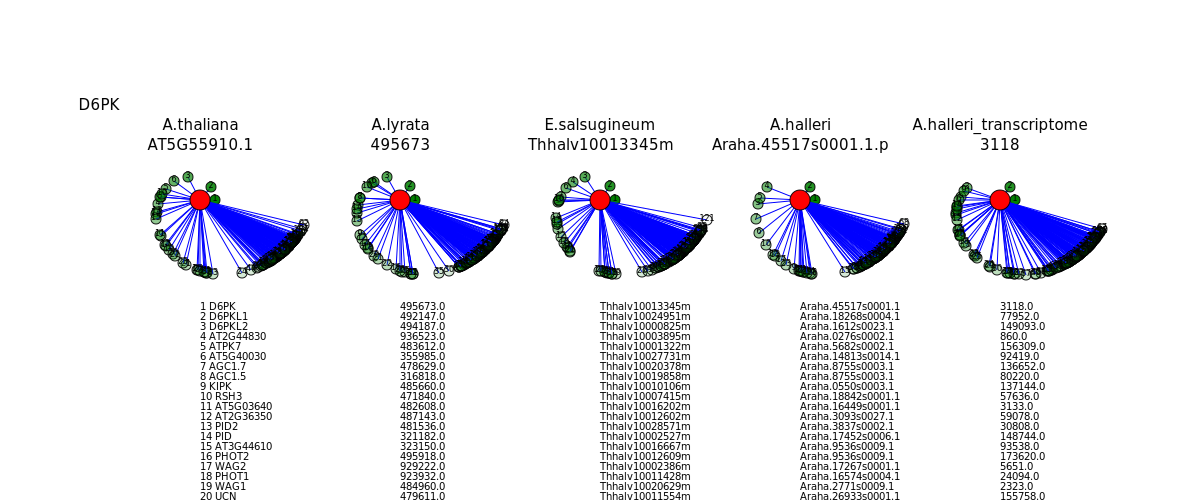

In [127]:
draw_orthologs('AT5G55910.1','D6PK')

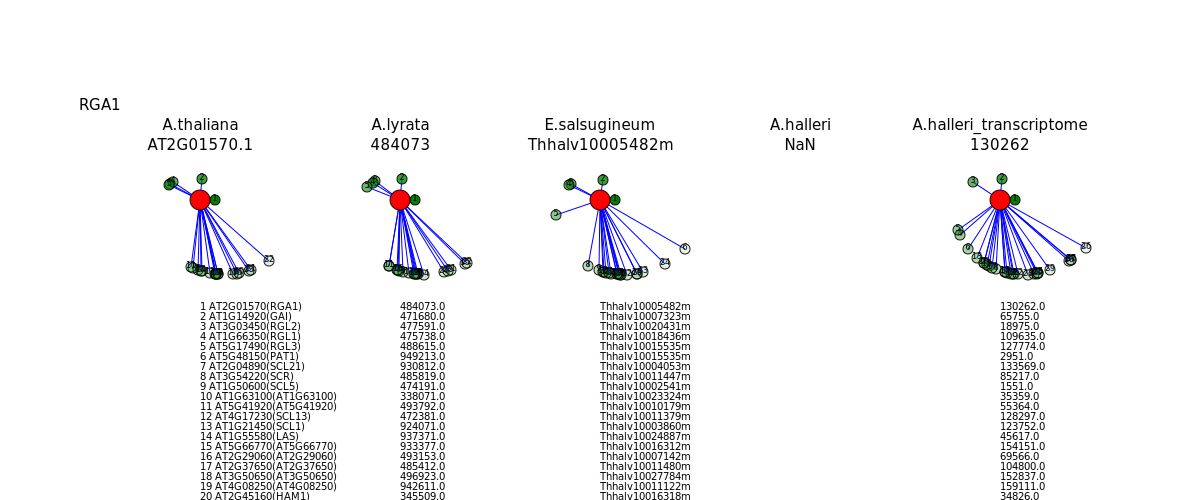

In [231]:
draw_orthologs('AT2G01570.1','RGA1')

AT2G14260.1


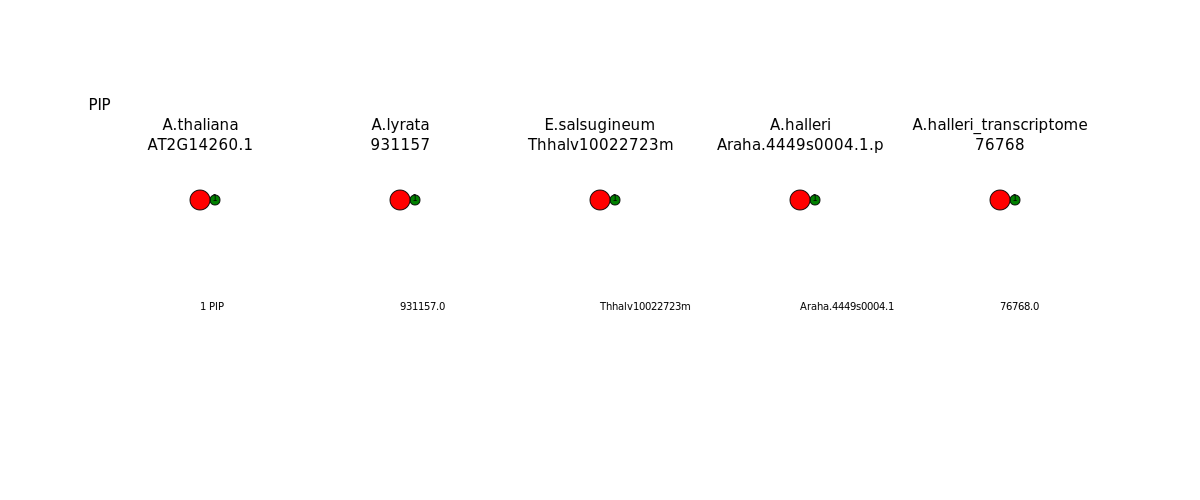

In [129]:
draw_orthologs('AT2G14260.1','PIP')

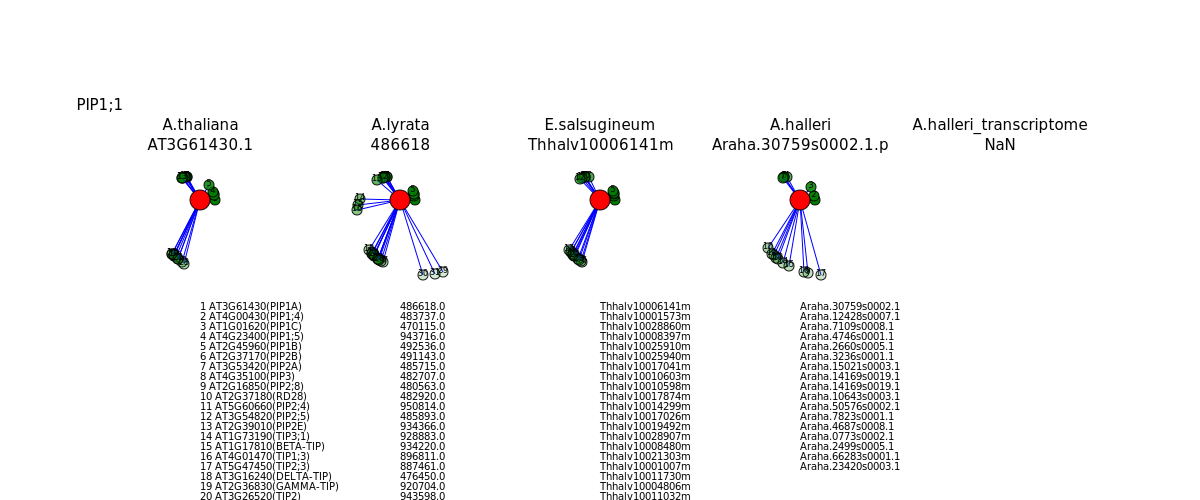

In [235]:
draw_orthologs('AT3G61430.1','PIP1;1')

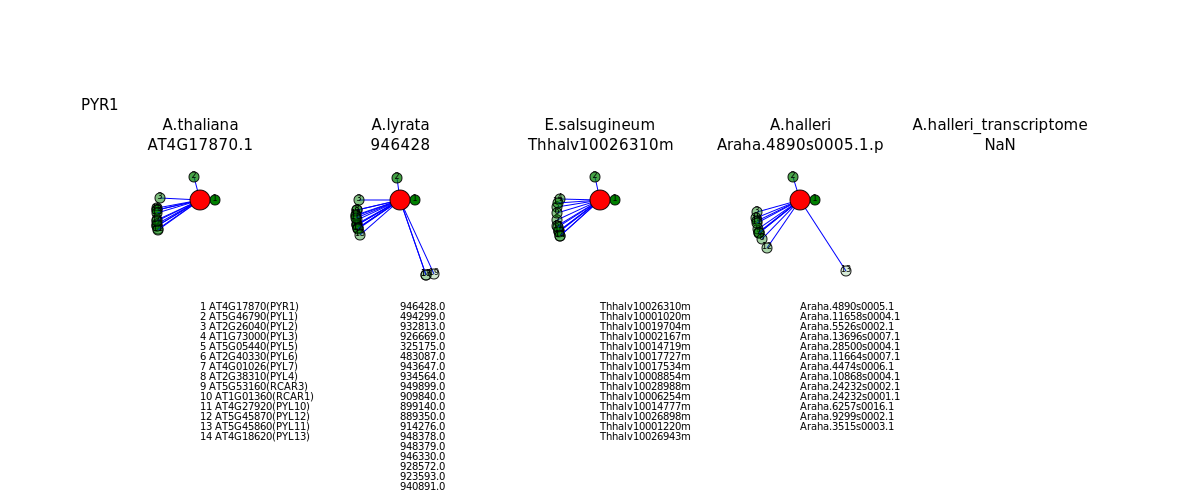

In [234]:
draw_orthologs('AT4G17870.1','PYR1')

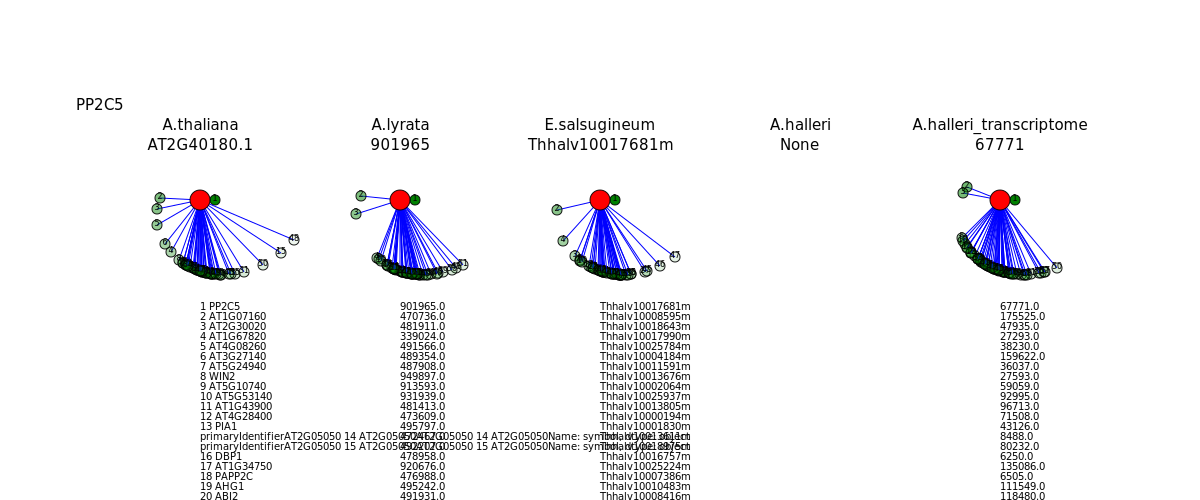

In [133]:
draw_orthologs('AT2G40180.1','PP2C5')

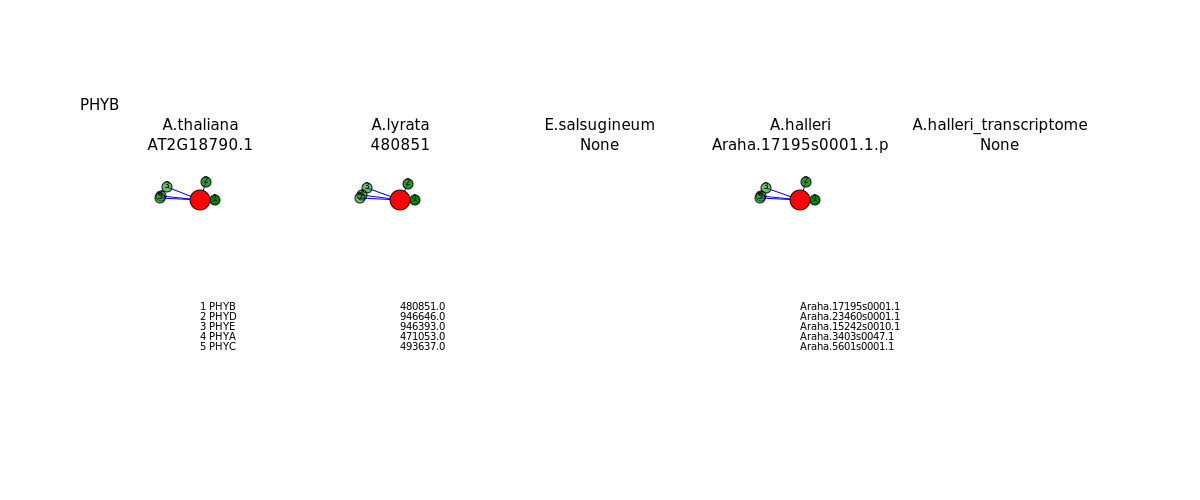

In [135]:
draw_orthologs('AT2G18790.1','PHYB')

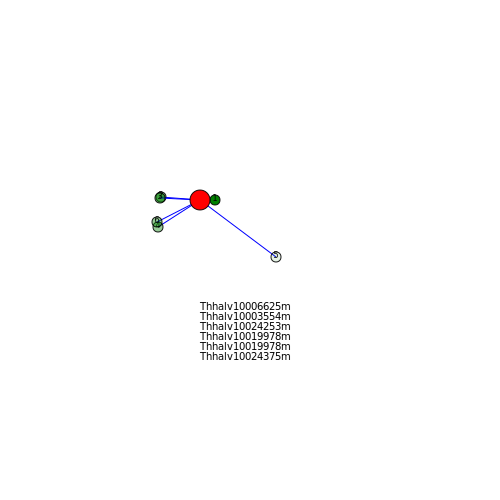

In [225]:
draw_genename(df_bo_es,'Thhalv10006625m')

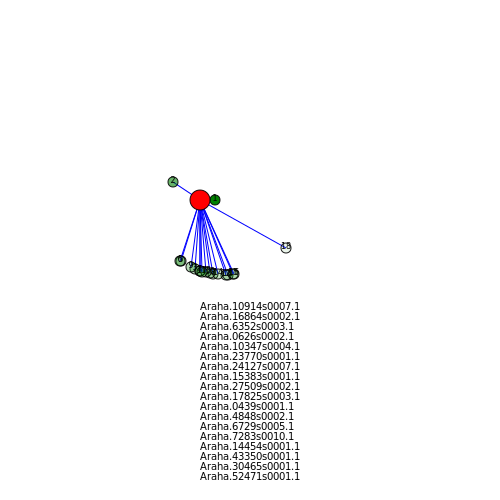

In [237]:
draw_genename(df_bo_ah,'Araha.10914s0007.1')

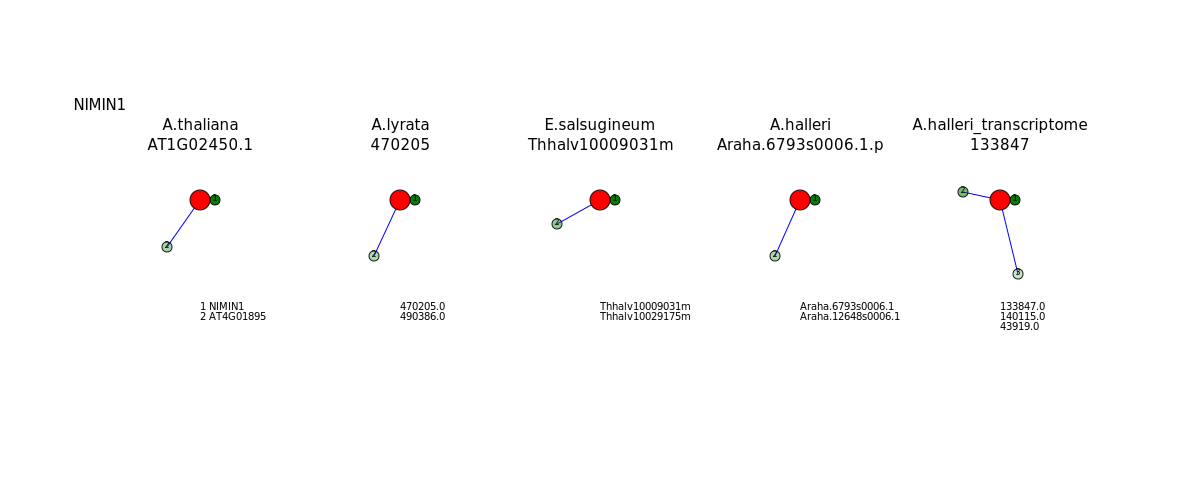

In [226]:
draw_orthologs('AT1G02450.1','NIMIN1')

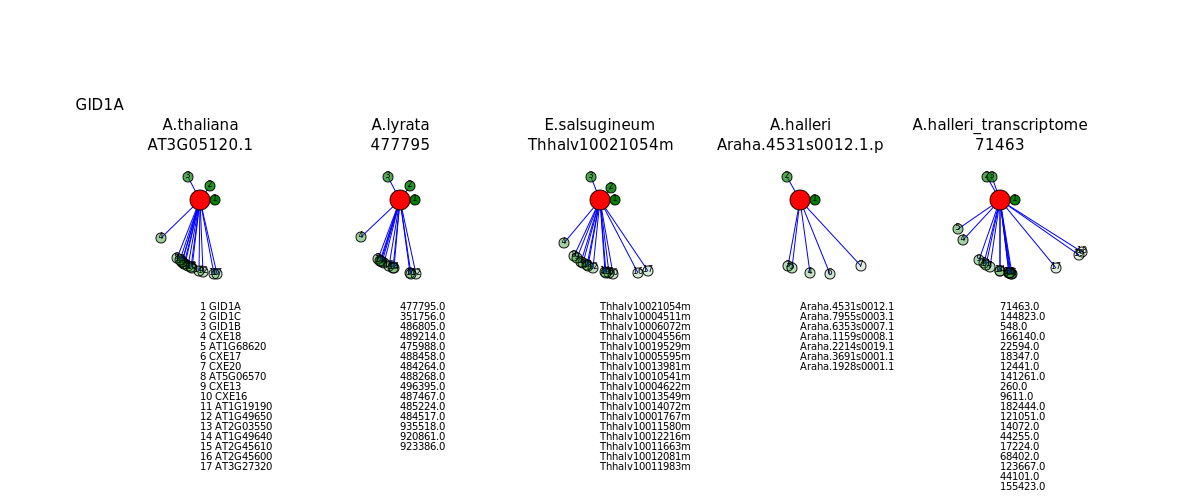

In [227]:
draw_orthologs('AT3G05120.1','GID1A')

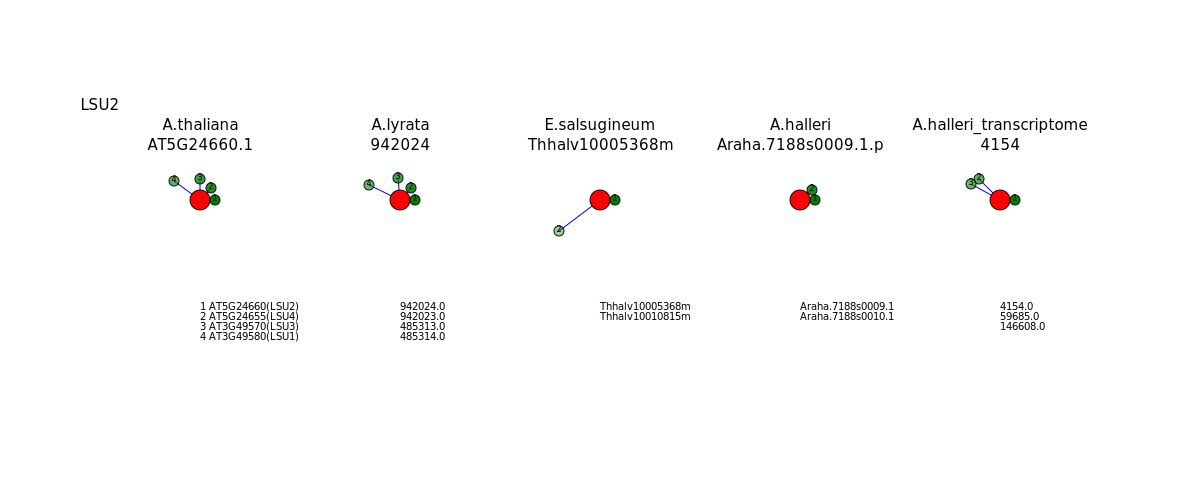

In [230]:
draw_orthologs('AT5G24660.1','LSU2')

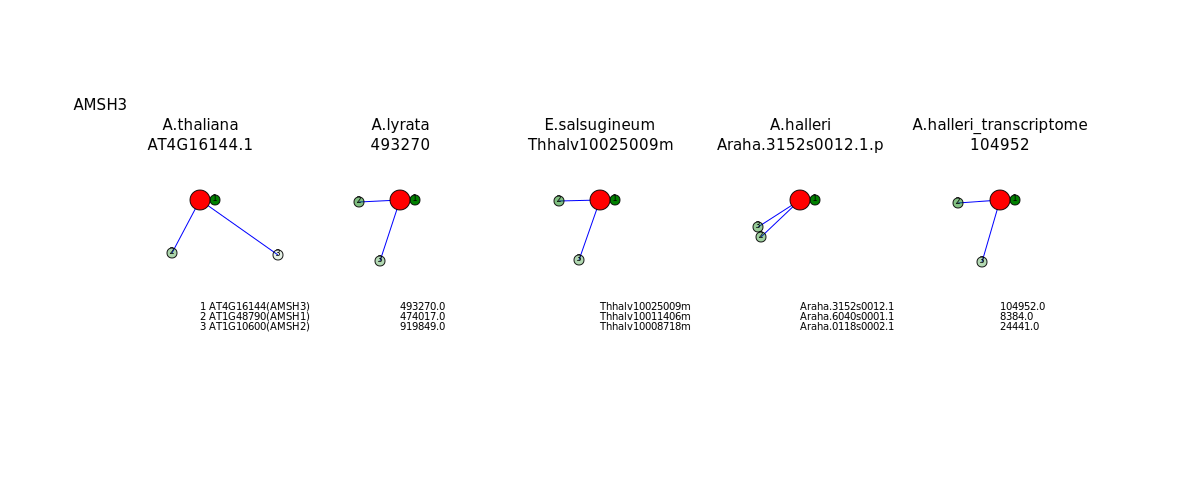

In [233]:
draw_orthologs('AT4G16144.1','AMSH3')

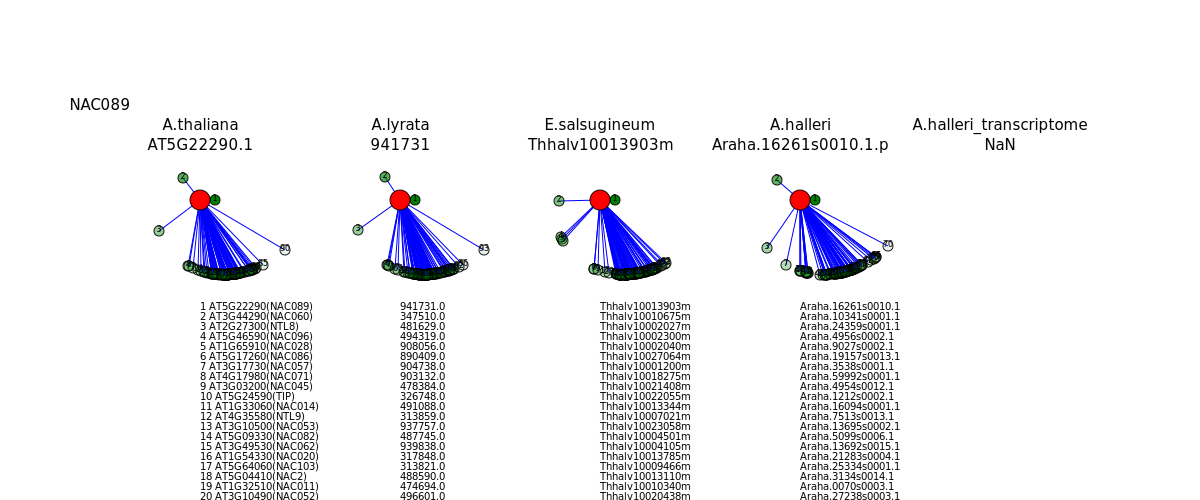

In [236]:
draw_orthologs('AT5G22290.1','NAC089')

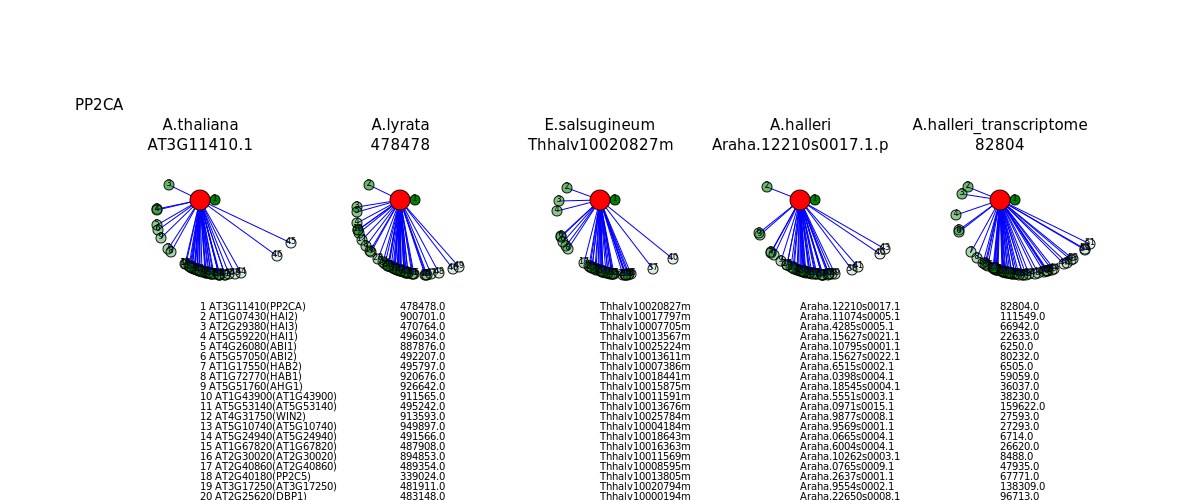

In [238]:
draw_orthologs('AT3G11410.1','PP2CA')

- Under the arabidopsis circles, it would be better to list the protein homologs

In [69]:
df_bo_ah.head()

,1,2,3,4,5,6,7,8,9,10,11,ql,sl,msim,x,y,l,theta
0,,,,,,,,,,,,,,,,,,
Araha.10973s0009.1,Araha.10973s0009.1,100.00,403,0,0,1,403,1,403,0,823,403,403,1.000000,15.000000,0.000000,15.000000,0.000000
Araha.13924s0015.1,Araha.13924s0015.1,100.00,585,0,0,1,585,1,585,0,1213,585,585,1.000000,15.000000,0.000000,15.000000,0.000000
Araha.13924s0015.1,Araha.33049s0003.1,67.80,590,167,7,1,584,1,573,0,805,585,593,0.679151,-10.891753,22.829290,25.294401,2.015953
Araha.13924s0015.1,Araha.13924s0014.1,66.96,572,167,8,6,571,7,562,0,779,585,651,0.619759,-21.504663,20.133087,29.458305,2.389123
Araha.13924s0015.1,Araha.1853s0010.1,51.38,580,256,13,11,578,11,576,0,570,585,588,0.508106,-39.145176,1.995377,39.195999,3.090663


In [173]:
df_ortholog.head()

,Genename,ALY,ESA,AHA,AHA1
0,AT4G04480.1,490095,Thhalv10028702m,Araha.34216s0001.1.p,NaN
1,AT1G31380.1,NaN,NaN,NaN,NaN
2,AT1G03340.1,919001,Thhalv10007898m,Araha.5052s0028.1.p,166211
3,AT1G04440.1,919122,Thhalv10007554m,Araha.5667s0005.1.p,26132
4,AT5G13090.1,488125,Thhalv10015811m,Araha.3287s0009.1.p,NaN


In [208]:
print ('total number of arabidopsis genes', len(df_ortholog))

mask = (df_ortholog['ALY'] == 'NaN') & (df_ortholog['ESA'] == 'NaN') & (df_ortholog['AHA'] == 'NaN') & (df_ortholog['AHA1'] == 'NaN')

print( 'total number of arabidopsis genes without any orthologous genes with three species',len(df_ortholog[mask]))

mask = (df_ortholog['ALY'] != 'NaN') & (df_ortholog['ESA'] != 'NaN') & (df_ortholog['AHA'] != 'NaN') & (df_ortholog['AHA1'] == 'NaN')
print( 'total number of arabidopsis genes without orthologous genes only in A.ha transcriptome assembly',len(df_ortholog[mask]))

mask = (df_ortholog['ALY'] != 'NaN') & (df_ortholog['ESA'] != 'NaN') & (df_ortholog['AHA'] == 'NaN') & (df_ortholog['AHA1'] != 'NaN')
print( 'total number of arabidopsis genes without orthologous genes only in A.ha gene model',len(df_ortholog[mask]))

mask = (df_ortholog['ALY'] != 'NaN') & (df_ortholog['ESA'] != 'NaN') & (df_ortholog['AHA'] == 'NaN') & (df_ortholog['AHA1'] == 'NaN')
print( 'total number of arabidopsis genes without orthologous genes in A.ha gene model and transcriptome assembly',len(df_ortholog[mask]))

mask = (df_ortholog['ALY'] != 'NaN') & (df_ortholog['ESA'] == 'NaN') & (df_ortholog['AHA'] != 'NaN') & (df_ortholog['AHA1'] != 'NaN')
print( 'total number of arabidopsis genes without orthologous genes only in E.sa gene model',len(df_ortholog[mask]))

mask = (df_ortholog['ALY'] == 'NaN') & (df_ortholog['ESA'] != 'NaN') & (df_ortholog['AHA'] != 'NaN') & (df_ortholog['AHA1'] != 'NaN')
print( 'total number of arabidopsis genes without orthologous genes only in A.ly gene model',len(df_ortholog[mask]))

total number of arabidopsis genes 27416
total number of arabidopsis genes without any orthologous genes with three species 3257
total number of arabidopsis genes without orthologous genes only in A.ha transcriptome assembly 3155
total number of arabidopsis genes without orthologous genes only in A.ha gene model 2194
total number of arabidopsis genes without orthologous genes in A.ha gene model and transcriptome assembly 961
total number of arabidopsis genes without orthologous genes only in E.sa gene model 881
total number of arabidopsis genes without orthologous genes only in A.ly gene model 556


In [206]:
df_ortholog[mask].head()

,Genename,ALY,ESA,AHA,AHA1
25,AT2G26190.1,NaN,Thhalv10001975m,Araha.11947s0001.1.p,2370
69,AT5G16680.1,NaN,Thhalv10012458m,Araha.21995s0003.1.p,25016
209,AT3G02850.1,NaN,Thhalv10020072m,Araha.4629s0004.1.p,55373
270,AT5G47800.1,NaN,Thhalv10000839m,Araha.56374s0004.1.p,5182
378,AT4G00950.1,NaN,Thhalv10028866m,Araha.5007s0001.1.p,5248
